This notebook reads in unfilt, unwrapped igrams (sequential and skip1 igrams) and calculates triplets to make sure the (a-b) + (b-c) - (a-c) = 0. This will capture unwrapping errors if they are unequal before+after the date.
<br>
<br>
Notebook written on 3-29-23.
***

In [1]:
# import stuff
import os,sys
import glob
from osgeo import gdal
import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib  widget

Load in unfilt, unwrapped igrams (sequential and skip1 pairs).

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
unwr_full_res_skip1 = np.ndarray((numIgrams-1,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # skip1 igrams
    if i < numIgrams-1: # only doing skip1 igrams up through numIgrams-1
        date1=dates[i]
        date2=dates[i+2]
        igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        unwr_full_res_skip1[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped sequential and skip1 igrams loaded.')

unfiltered unwrapped sequential and skip1 igrams loaded.


Calculate triplets.

In [3]:
num_triplets = numIgrams-1
triplets = np.ndarray((num_triplets,dy,dx),dtype='float')

for i in range(num_triplets):
    triplets[i] = unwr_full_res[i]+unwr_full_res[i+1]-unwr_full_res_skip1[i]
print('triplets calculated.')
triplets_ints = np.round(triplets/(2*np.pi))
print('triplets in 2pi modulo, rounded calculated.')

triplets calculated.
triplets in 2pi modulo, rounded calculated.


In [4]:
del unwr_full_res 
del unwr_full_res_skip1

Plot one at a time.

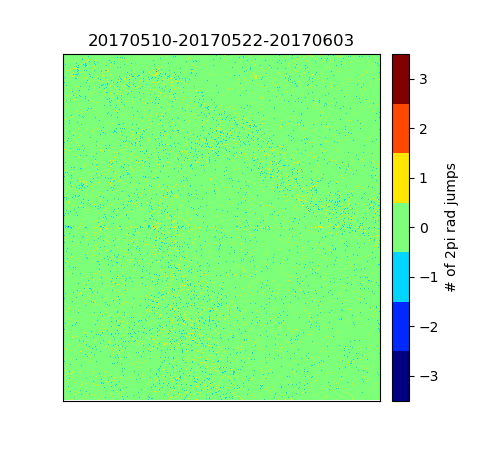

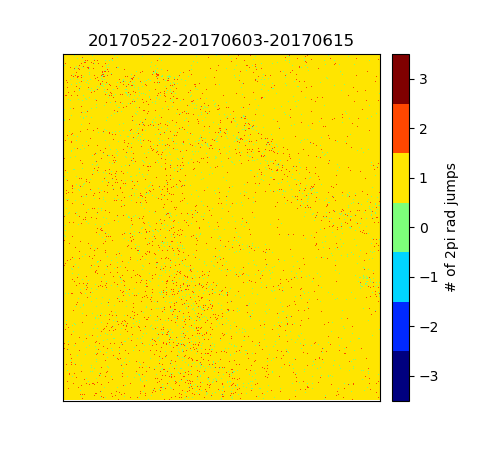

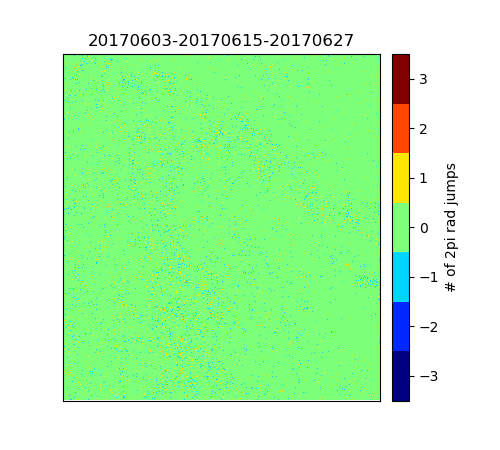

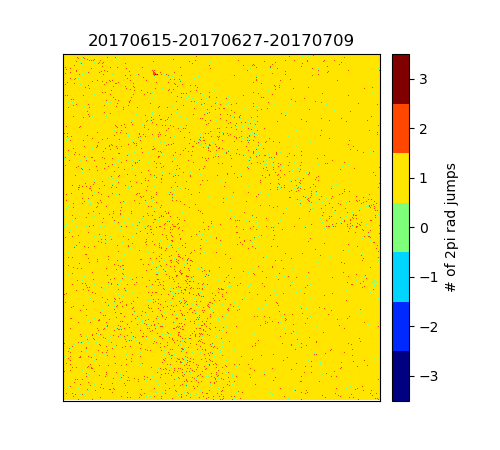

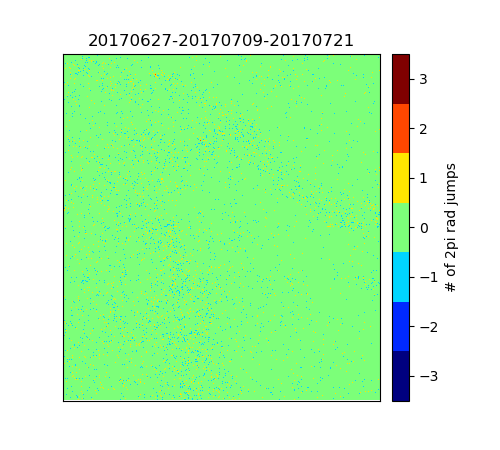

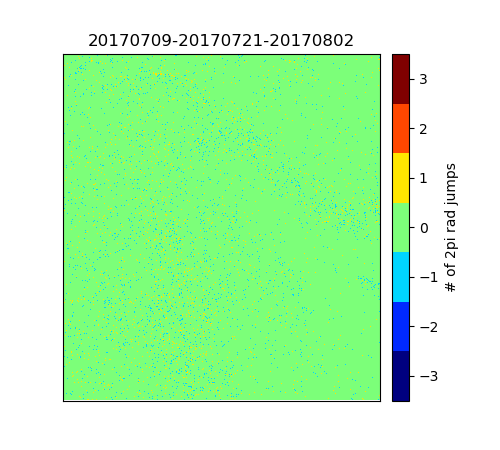

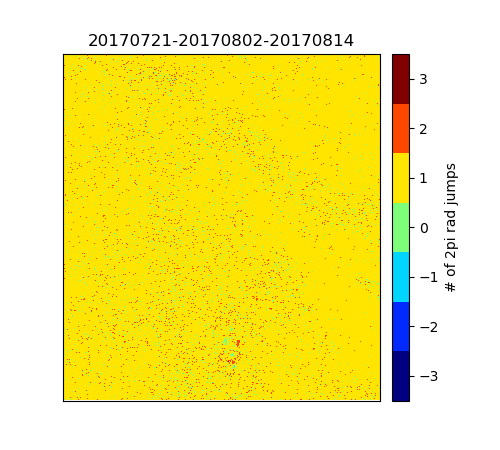

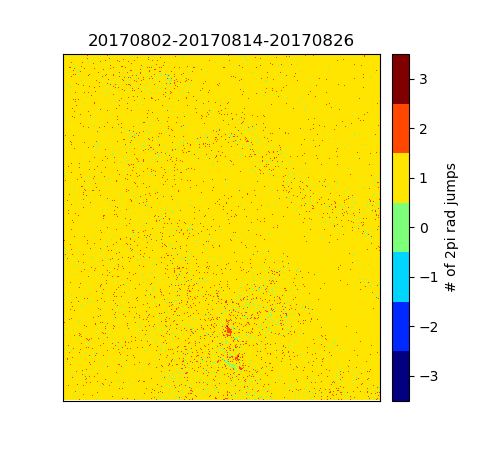

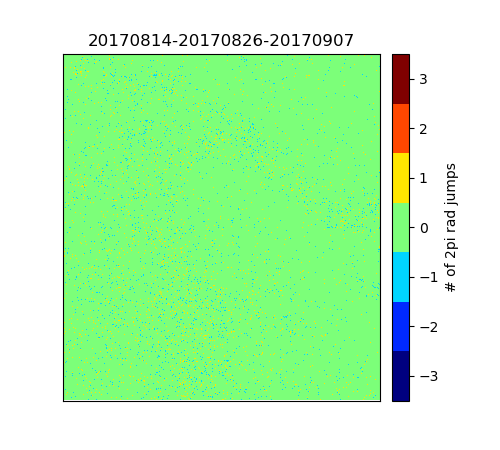

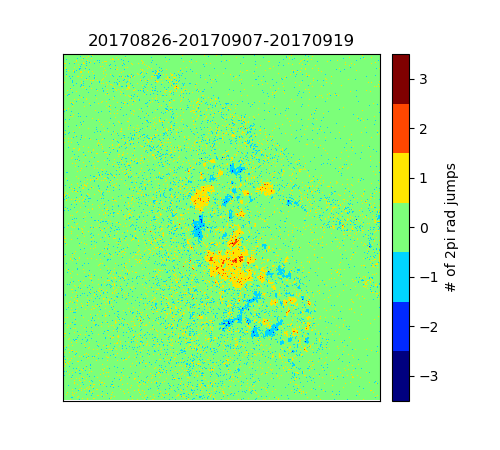

In [5]:
# to make discrete colormap that I like, I copied code from here: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

for k in np.arange(0,10,1): # for all, range(num_triplets)
    # 10-20 had a few issues
    # 69,70,72-73,110-111,152-153,181-184,190-191 have small spatial issues
    date1=dates[k]
    date2=dates[k+1]
    date3=dates[k+2]
    plt.figure(figsize=(5,4.5))
    plt.imshow(triplets_ints[k],aspect='auto',interpolation='nearest',vmin=-3.5,vmax=3.5,cmap=discrete_cmap(7,'jet'))
    plt.colorbar(orientation='vertical',pad=0.03,label='# of 2pi rad jumps')
    plt.xlim([dx,0]); plt.ylim([dy,0])
    plt.xticks([]); plt.yticks([]) #plt.xlabel('range'); plt.ylabel('azimuth')
    plt.title(str(date1)+'-'+str(date2)+'-'+str(date3))
    plt.show()